In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Neutron Interaction Resonances
================================================

First define all of the needed parameters and constants, being careful with units.

In [2]:
A = 238                             # ratio of nuclear mass to neutron mass
a = (0.123*A**(1.0/3.0) + 0.08)*1e-12   # hard-sphere radius of nucleus, cm
I = 0                               # target spin, unitless
J = 0.5                             # compound nucleus spin, unitless
E_i = 6.67                          # location of resonance, eV
Gamma_i  = 0.02752                  # total resonance width, eV
Gamma_ni = 0.00152                  # neutron partial width, eV
Gamma_gi = 0.026                    # radiative capture partial width, eV
c = 2.99792458e10                   # speed of light in vacuum, cm/s
m = 939.57e6/c**2                   # mass of neutron, eV/c^2 = eV s^2/cm^2
hbar = 4.135667662e-15/(2.0*np.pi)  # reduced plank's constant, eV s
k = 8.61734e-5                      # boltzmann constant, eV/K
gJ = (2*J+1)/(2*(2*I+1))            # statistical spin factor, unitless

0K Single-Level Briet Wigner Capture and Elastic Scattering Cross Sections
-------------------------

First, create a function to calculate the neutron wavelength as a function of energy:  

$$\lambda = \frac{A+1}{A} \frac{\hbar}{\sqrt{2Em}}$$

In [3]:
def wavelength(E) : 
    return (A+1)/A*hbar/np.sqrt(2.0*E*m) # eV s/sqrt(eV eV s^2 / cm^2) = cm

Now create functions to calculate $\sigma_0$ and the s-wave potential cross section, $\sigma_p^0$, as functions of energy, where

$$\sigma_0 = 4\pi \lambda^2 g_J \frac{\Gamma_{n,1}}{\Gamma_i}$$

and

$$\sigma_p^0 = 4\pi \lambda^2 \sin^2 \frac{a}{\lambda}$$

In [4]:
def sigma0(E) :
    return 4.0*np.pi*wavelength(E)**2*gJ*Gamma_ni/Gamma_i  # cm^2

In [5]:
def sigmap(E) :
    lmbda = wavelength(E)
    return 4.0*np.pi*lmbda**2*np.sin(a/lmbda)**2

Now we have everything in place to calculate the the capture and elastic scattering cross sections.  Rather than doing the actual calculation here, I am going to create two functions that will do the calculation as a function of energy.  The function `sigma_g` will calculate the capture cross section given by 

$$\sigma_g(E) = \sigma_0(E) \frac{\Gamma_{g,i}\Gamma_i}{\Gamma_i^2+4(E-E_i)^2}$$

while the function `sigma_e` will calculate the elastic scattering cross section given by

$$\sigma_e(E) = \sigma_p^0(E) 
              + \sigma_0(E) \left[ \frac{2}{\Gamma_i}(E-E_i) \sin 2\frac{a}{\lambda} 
              + \frac{\Gamma_{n,i}}{\Gamma_i} -2 \sin^2 \frac{a}{\lambda} \right] \frac{\Gamma_i^2}{\Gamma_i^2+4(E-E_i)^2}$$

In [6]:
def sigma_g(E) :
    return sigma0(E)*Gamma_gi*Gamma_i/(Gamma_i**2 + 4.0*(E-E_i)**2)

In [7]:
def sigma_e(E) :
    phi0 = a/wavelength(E)
    return sigmap(E)**2 + sigma0(E)*(2/Gamma_i*(E-E_i)*np.sin(2.0*phi0) + Gamma_ni/Gamma_i - 2.0*np.sin(phi0)**2)*Gamma_i**2/(Gamma_i**2 + 4.0*(E-E_i)**2)

Calculate and plot:

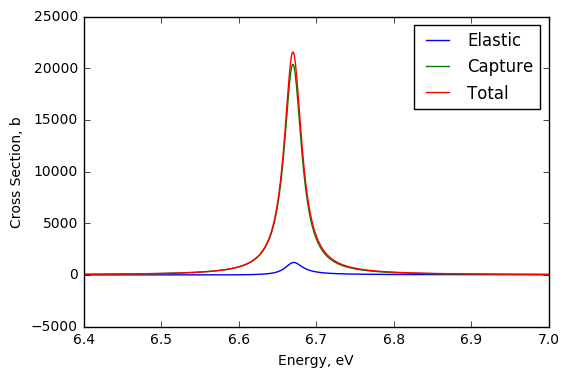

In [8]:
E = np.linspace(6.4,7.0,1000)
sigmae0 = sigma_e(E)*1.0e24  # elastic cross section, barns
sigmag0 = sigma_g(E)*1.0e24  # capture cross section, barns
sigmat0 = sigmag0+sigmae0      # total cross section, barns

elastic, = plt.plot(E,sigmae0)
capture, = plt.plot(E,sigmag0)
total,   = plt.plot(E,sigmat0)
plt.legend([elastic,capture,total],['Elastic','Capture','Total'])
plt.xlabel('Energy, eV')
plt.ylabel('Cross Section, b')
plt.savefig('xs0.png',dpi=150)

Doppler Broadened Cross Sections
--------------------------------

Now let's calculate Doppler broadened cross sections.  We will do this using the $\psi-\phi$ formulation under the assumption $\alpha = 0$.  Thus we need to evaluate

$$\psi(u,\beta) = \frac{1}{\beta\sqrt{\pi}}
                         \int_{-\infty}^\infty dv \frac{1}{1+v^2} 
                         \exp\left[ -\frac{(v-u)^2}{\beta^2}\right]$$

and

$$\phi(u,\beta) = \frac{1}{\beta\sqrt{\pi}}
                         \int_{-\infty}^\infty dv \frac{v}{1+v^2} 
                         \exp\left[ -\frac{(v-u)^2}{\beta^2}\right]$$

where $u = \frac{2}{\Gamma_i}(E-E_i)$, $\beta = \frac{2\Gamma_D}{\Gamma_i}$ and $\Gamma_D = 2 \sqrt{\frac{E_i kT}{A}}$.

The $\psi$ and $\phi$ functions are evaluated using a Gauss-Hermite quadrature.  This form of evaluation is only accurate at very low energies due to the shape of the integrand (which can become highly peaked).  I am using 200 quadrature points to get rid of the oscillations that result from a poor approximation.  To get the integrals in the right form for the quadrature we should make the substitution $x = \frac{v-u}{\beta}$, which leads to

$$\psi(u,\beta) = \frac{1}{\sqrt{\pi}}
                         \int_{-\infty}^\infty dx \frac{1}{1+\left( u+x\beta \right)^2} e^{-x^2}$$

and

$$\phi(u,\beta) = \frac{1}{\sqrt{\pi}}
                         \int_{-\infty}^\infty dx \frac{u+x\beta}{1+\left( u+x\beta \right)^2} e^{-x^2}$$



In [9]:
def psi(u,beta) :
    (x,w) = np.polynomial.hermite.hermgauss(200)
    quadSum = 0.0
    for i in range(len(x)) :
        quadSum += 1.0/(1.0 + (x[i]*beta+u)**2)*w[i]
    return 1.0/(np.sqrt(np.pi))*quadSum

def phi(u,beta) :
    (x,w) = np.polynomial.hermite.hermgauss(200)
    quadSum = 0.0
    for i in range(len(x)) :
        quadSum += (x[i]*beta+u)/(1.0 + (x[i]*beta+u)**2)*w[i]
    return 1.0/(np.sqrt(np.pi))*quadSum

In [10]:
(x,w) = np.polynomial.hermite.hermgauss(5)

In [11]:
print x
print w
sum(w)

[-2.02018287 -0.95857246  0.          0.95857246  2.02018287]
[ 0.01995324  0.39361932  0.94530872  0.39361932  0.01995324]


1.7724538509055159

We can now write a function to calculate the Doppler-broadened capture cross section

$$\bar{\sigma}_x(E) = \sigma_0(E) \frac{\Gamma_{x,i}}{\Gamma_i} \psi(u(E),\beta)$$

In [12]:
def sigma_g_Doppler(E,T) :
    u = 2.0/Gamma_i*(E-E_i)
    GammaD = 2.0*np.sqrt(E_i*k*T/A)
    beta = 2.0*GammaD/Gamma_i
    return sigma0(E)*Gamma_gi/Gamma_i*psi(u,beta)

Calculate and plot:

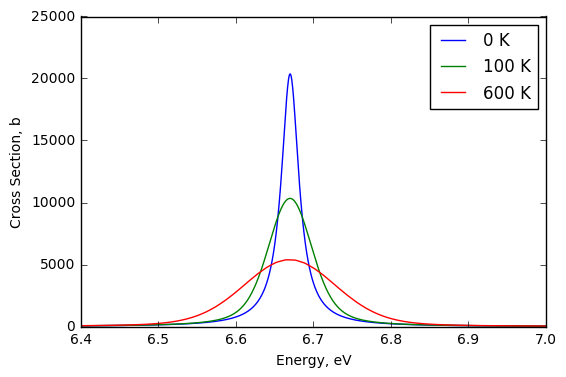

In [13]:
sigmag100 = sigma_g_Doppler(E,100)*1.0e24  # capture cross section, barns
sigmag600 = sigma_g_Doppler(E,600)*1.0e24  # capture cross section, barns


capture0, = plt.plot(E,sigmag0)
capture100, = plt.plot(E,sigmag100)
capture600, = plt.plot(E,sigmag600)
plt.legend([capture0,capture100,capture600],["0 K","100 K","600 K"])
plt.xlabel('Energy, eV')
plt.ylabel('Cross Section, b')
plt.savefig('capture_broad.png',dpi=150)

The Doppler broadened scatter cross section is 

$$\bar{\sigma}_e(E) = 4\pi a^2 + \sigma_0(E)\frac{2a}{\lambda}\phi(u(E),\beta) + \sigma_0(E)\frac{\Gamma_{n,i}}{\Gamma_i}\psi(u(E),\beta)$$

which I implement in the following function.

In [14]:
def sigma_e_Doppler(E,T) :
    u = 2.0/Gamma_i*(E-E_i)
    GammaD = 2.0*np.sqrt(E_i*k*T/A)
    beta = 2.0*GammaD/Gamma_i
    return 4.0*np.pi*a**2 + sigma0(E)*(2.0*a/wavelength(E)*phi(u,beta) + Gamma_ni/Gamma_i*psi(u,beta))

Calculate and plot:

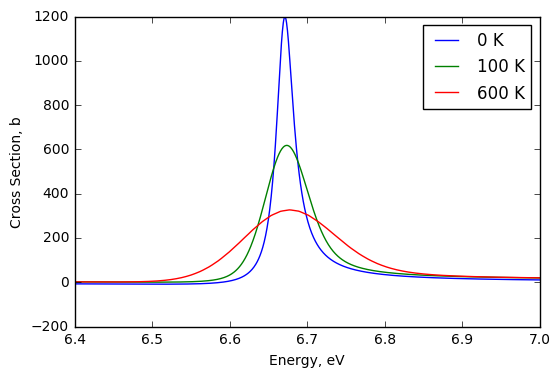

In [15]:
sigmae100 = sigma_e_Doppler(E,100)*1.0e24  # capture cross section, barns
sigmae600 = sigma_e_Doppler(E,600)*1.0e24  # capture cross section, barns


elastic0, = plt.plot(E,sigmae0)
elastic100, = plt.plot(E,sigmae100)
elastic600, = plt.plot(E,sigmae600)
plt.legend([elastic0,elastic100,elastic600],["0 K","100 K","600 K"])
plt.xlabel('Energy, eV')
plt.ylabel('Cross Section, b')
plt.savefig('scatter_broad.png',dpi=150)

Flux Spectrum In A Resonance
----------------------------

Let's look at this resonances effect on the flux spectrum.  For neutrons to be slowing down past the resonance, we need a moderating material.  Let's use hydrogen and calculate its potential cross section using the hard-sphere formula for nuclear radius.  I will also define the ratio of moderator number density to absorber density as 115.

In [16]:
sigmaSM = 4.0*np.pi*(0.123 + 0.08)**2   # b
NMtoNR = 115.0

Now use the narrow resonance approximations to estimate the the spectrum in and around the resonance.  Given the current assumptions the narrow resonance approximation can be written

$$\phi_\text{NR}(E) = \frac{\frac{N^M}{N^\text{res}}\sigma_s^M + \sigma_p^{0,\text{res}}}{\left[ \frac{N^M}{N^\text{res}}\sigma_s^M + \sigma_t^\text{res}(E) \right]E}$$

where $\phi_\text{NR}(E)$ is the flux spectrum, not to be confused with the Doppler-$\phi$ function!

In [17]:
sigmaSRes = sigma_e(E)*1.0e24    # elastic cross section, barns
sigmaARes = sigma_g(E)*1.0e24    # capture cross section, barns
sigmaTRes = sigmaARes+sigmaSRes  # total cross section, barns

phi_NR = (NMtoNR*sigmaSM + sigmap(E))/((sigmaTRes + NMtoNR*sigmaSM)*E)

Let's plot the flux superimposed over the capture cross section to make sure everything looks right.

/Users/justinpounders/anaconda/lib/python2.7/site-packages/matplotlib/legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x1136a11d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


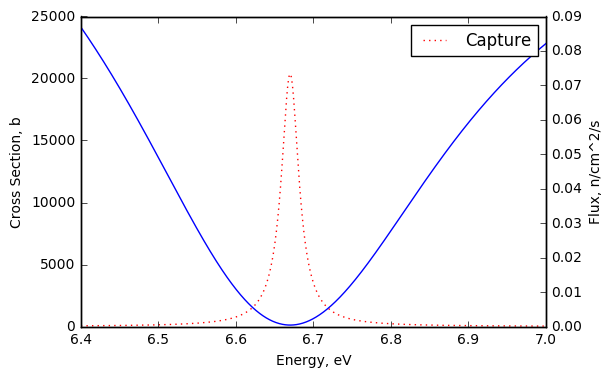

In [18]:
fig, ax1 = plt.subplots()
capture, = ax1.plot(E,sigmaARes,":r")
ax1.set_xlabel("Energy, eV")
ax1.set_ylabel("Cross Section, b")

ax2 = ax1.twinx()
nrSpec = ax2.plot(E,phi_NR)
ax2.set_ylabel('Flux, n/cm^2/s')

plt.legend([capture,nrSpec],["Capture","NR"])
plt.savefig('selfshielding.png',dpi=150)

Now let's look at the effect of Doppler broadening.  I will use the narrow resonance approximation with the 0 K and Doppler broadened cross sections from the last section.

In [19]:
EE = np.linspace(6.0,7.4,1000)
sigmaTRes0 = (sigma_g_Doppler(EE,0.0)+sigma_e_Doppler(EE,0.0))*1.0e24  # total cross section, barns
sigmaTRes100 = (sigma_g_Doppler(EE,100.0)+sigma_e_Doppler(EE,100.0))*1.0e24  # total cross section, barns
sigmaTRes600 = (sigma_g_Doppler(EE,600.0)+sigma_e_Doppler(EE,600.0))*1.0e24  # total cross section, barns

phi_NR0 = (NMtoNR*sigmaSM + sigmap(EE))/((sigmaTRes0 + NMtoNR*sigmaSM)*EE)
phi_NR100 = (NMtoNR*sigmaSM + sigmap(EE))/((sigmaTRes100 + NMtoNR*sigmaSM)*EE)
phi_NR600 = (NMtoNR*sigmaSM + sigmap(EE))/((sigmaTRes600 + NMtoNR*sigmaSM)*EE)

And plot...

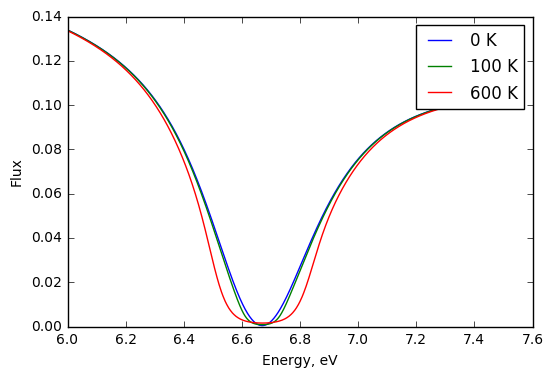

In [20]:
nr0,nr100,nr600 = plt.plot(EE,phi_NR0, EE,phi_NR100, EE,phi_NR600)

plt.legend([nr0,nr100,nr600],["0 K","100 K","600 K"])
plt.xlabel('Energy, eV')
plt.ylabel('Flux')
plt.savefig('selfshielding_broadZoom.png',dpi=150)

Neutron Capture Rates
---------------------

The capture rate for a given resonance capture cross section $\sigma_g(E)$ is

$$R = \int_0^\infty N^\text{res}\sigma_g(E) \phi(E) dE.$$

Here I will pick $N^\text{res} = 1.0$ inverse barn-cm, so that if the capture cross section is in barns and the flux is in units of inverse cm$^2$-sec then $R$ will have units of inverse cm$^3$.

Because I calculated the flux spectra on a uniform energy grid, then I can approximate the capture integral using

$$R \approx h \sum_j \sigma_g(E_j) \phi(E_j)$$

where $h$ is the energy spacing and $j$ is the index into my energy points.  Of course, the total energy range should be sufficiently wide to include all of the significant capture region.

In [21]:
h = EE[1]-EE[0]
print "Capture rate at 0 K   = ", np.sum(phi_NR0*sigma_g_Doppler(EE,0.0))*h*1.0e24
print "Capture rate at 100 K = ", np.sum(phi_NR100*sigma_g_Doppler(EE,100.0))*h*1.0e24
print "Capture rate at 600 K = ", np.sum(phi_NR600*sigma_g_Doppler(EE,600.0))*h*1.0e24

Capture rate at 0 K   =  5.12622437553
Capture rate at 100 K =  5.19089847927
Capture rate at 600 K =  5.50932436798
